In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import joblib
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import metrics


In [4]:
df = pd.read_csv('DataNew.csv',index_col=0)

In [6]:
#First Step -> Tokenize and padd
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") #num_words : the maximum number of words to keep, based on word frequency (for the 45232 products information), #oov : out-of-vocabulary token, it is agregated to words which are not in the 10000 most frequent ones
tokenizer.fit_on_texts(df['name and description']) # encoding words of information to integers, Updates internal vocabulary based on a list of sequences.
word_index = tokenizer.word_index
print("Amount of different words through the 45232 products information:",len(word_index))
sequences = tokenizer.texts_to_sequences(df['name and description'])
print("Amount of sequences:", len(sequences)) #Should be equal to the amount of products 
print("Sequences Examples:",sequences[0], sequences[1], sequences[2], sequences[3], sequences[4]) #This is how the first 5 products info are represented, each number represent a word in "word_index" dict.
padded = pad_sequences(sequences, padding="post") #This takes the maxlen parameter as a referene and makes all the lists of the same lenght adding zeros on the left spaces, if nothins is pass ot will take the longest sequence as a reference
print("First Sequence padded: \n",padded[0])
print(len(padded[0]), len(padded[1]), len(padded[2])) #Should all be equal to 
print("Dataset Padded Shape:", padded.shape)

Amount of different words through the 45232 products information: 40953
Amount of sequences: 45237
Sequences Examples: [3598, 1784, 579, 2956, 13, 186, 47, 1784, 350, 5007, 12, 3304, 20, 45] [3598, 1263, 107, 1, 579, 1, 1530, 5007, 12, 3304, 20, 3133, 1, 1294, 518, 3666, 7032] [3598, 1263, 579, 2956, 13, 186, 47, 1263, 350, 5007, 12, 3304, 20, 45] [2124, 1201, 579, 1263, 1, 1263, 4517, 579, 35, 7976, 95] [3598, 373, 579, 2956, 13, 186, 47, 373, 350, 5007, 12, 3304, 20, 45]
First Sequence padded: 
 [3598 1784  579 2956   13  186   47 1784  350 5007   12 3304   20   45
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
57 57 57
Dataset Padded Shape: (45237, 57)


In [7]:
from sklearn.model_selection import train_test_split

In [9]:
# Splitting dataset in train/test set
X_train, X_test, y_train, y_test = train_test_split(padded, df[df.columns[1:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0)

In [10]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [11]:
num_classes = y_train.shape[1]
print(num_classes)
max_words = len(word_index) + 1
print(max_words)
maxlen = len(padded[0])
print(maxlen)

887
40954
57


In [56]:
#Let´s buils our NN BaseLine Model
model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen)) 
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=['Precision','Recall', tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(), # Reduce learning rate when a metric has stopped improving
    ModelCheckpoint(filepath='model-neural-net.h5', save_best_only=True)
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 57, 300)           12286200  
                                                                 
 dense_1 (Dense)             (None, 57, 300)           90300     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 887)               266987    
                                                                 
Total params: 12,643,487
Trainable params: 12,643,487
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.3, callbacks=callbacks)


Epoch 1/30
693/693 [==============================] - 214s 306ms/step - loss: 0.0146 - precision: 0.6296 - recall: 0.5789 - auc_1: 0.9128 - val_loss: 0.0108 - val_precision: 0.7837 - val_recall: 0.6668 - val_auc_1: 0.9239 - lr: 0.0150
Epoch 2/30
693/693 [==============================] - 205s 296ms/step - loss: 0.0117 - precision: 0.7586 - recall: 0.7284 - auc_1: 0.9325 - val_loss: 0.0127 - val_precision: 0.7477 - val_recall: 0.7258 - val_auc_1: 0.9314 - lr: 0.0150
Epoch 3/30
693/693 [==============================] - 206s 298ms/step - loss: 0.0084 - precision: 0.8095 - recall: 0.7685 - auc_1: 0.9538 - val_loss: 0.0090 - val_precision: 0.8020 - val_recall: 0.7448 - val_auc_1: 0.9503 - lr: 0.0150
Epoch 4/30
693/693 [==============================] - 206s 297ms/step - loss: 0.0066 - precision: 0.8327 - recall: 0.7847 - auc_1: 0.9655 - val_loss: 0.0094 - val_precision: 0.8041 - val_recall: 0.7347 - val_auc_1: 0.9456 - lr: 0.0150
Epoch 5/30
693/693 [==============================] - 207s 2

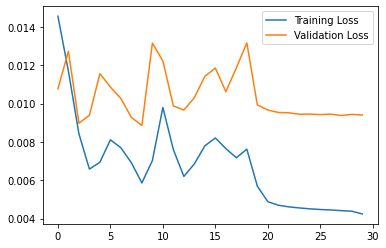

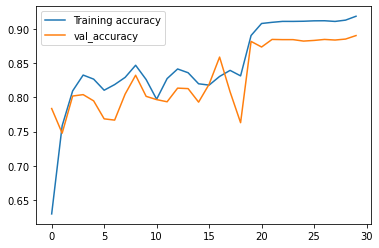

In [58]:
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["precision"], label="Training accuracy")
plt.plot(history.history["val_precision"], label="val_accuracy")
plt.legend()
plt.show() 

In [12]:
from keras.layers import Activation, Flatten, Conv1D

In [13]:
optimizer = tf.keras.optimizers.Adam()

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(Dropout(0.21))
model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D()) # This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
model.add(Dropout(0.21))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Precision','Recall', tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model.summary()

2022-08-23 03:21:32.232097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-23 03:21:32.233072: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-23 03:21:32.234796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-HP-Laptop-15-bs1xx): /proc/driver/nvidia/version does not exist
2022-08-23 03:21:32.248504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 57, 300)           12286200  
                                                                 
 dropout (Dropout)           (None, 57, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 55, 300)           270300    
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense (Dense)               (None, 887)               266987    
                                                        

In [14]:
plot_model(model, to_file='model_nn_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [15]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/50
693/693 [==============================] - 194s 277ms/step - loss: 0.0309 - precision: 0.1677 - recall: 0.1019 - auc: 0.8125 - val_loss: 0.0136 - val_precision: 0.9086 - val_recall: 0.3006 - val_auc: 0.8982 - lr: 0.0010
Epoch 2/50
693/693 [==============================] - 187s 270ms/step - loss: 0.0106 - precision: 0.8844 - recall: 0.4345 - auc: 0.9304 - val_loss: 0.0077 - val_precision: 0.8936 - val_recall: 0.5797 - val_auc: 0.9663 - lr: 0.0010
Epoch 3/50
693/693 [==============================] - 189s 272ms/step - loss: 0.0066 - precision: 0.9029 - recall: 0.6212 - auc: 0.9719 - val_loss: 0.0054 - val_precision: 0.9107 - val_recall: 0.7005 - val_auc: 0.9815 - lr: 0.0010
Epoch 4/50
693/693 [==============================] - 189s 273ms/step - loss: 0.0047 - precision: 0.9150 - recall: 0.7163 - auc: 0.9857 - val_loss: 0.0044 - val_precision: 0.9198 - val_recall: 0.7529 - val_auc: 0.9844 - lr: 0.0010
Epoch 5/50
693/693 [==============================] - 190s 274ms/step - loss

In [52]:
import matplotlib.pyplot as plt


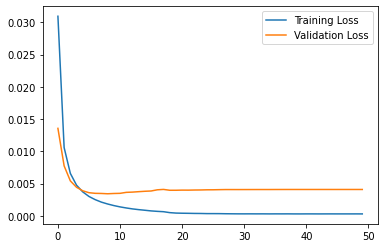

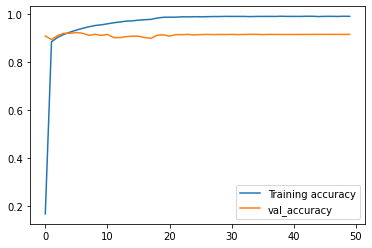

In [55]:
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["precision"], label="Training accuracy")
plt.plot(history.history["val_precision"], label="val_accuracy")
plt.legend()
plt.show() 

In [16]:
def get_standar_metrics(predictions, y_test):
  a = tranform_binary(predictions)
  print("Evaluation Metrics")
  print('-'*30)
  print("F1 Score:",metrics.f1_score(y_test, a, average="micro"))
  print("Recall Score:",metrics.recall_score(y_test, a, average="micro"))
  print("Precision Score:",metrics.precision_score(y_test, a, average="micro"))
  print("Hamming Loss:",metrics.hamming_loss(y_test, a), "\n")

In [17]:
def tranform_binary(predictions):
    a = predictions.tolist()
    for i in range(len(a)):
        for j in range(len(a[i])):
            if a[i][j] >= 0.5:
                a[i][j] = 1
            else:
                a[i][j] = 0

    a = np.array(a)
    return a

In [18]:
#Model Evaluation with Standar Metrics
predictions = model.predict(X_test, batch_size=32)
get_standar_metrics(predictions, y_test)

425/425 [==============================] - 5s 11ms/step
Evaluation Metrics
------------------------------
F1 Score: 0.8935396611580204
Recall Score: 0.8724896806895224
Precision Score: 0.915630470889258
Hamming Loss: 0.000807501750237823 



In [19]:
modeloF =  keras.models.load_model('model-conv1d.h5')

In [40]:
inp = 'Lenovo - 2022 - IdeaPad 3i - Essential Computer - Intel Core i5-15.6" FHD Display - 8GB Memory - 512GB Storage - Windows 11 Pro.'

x = tokenizer.texts_to_sequences([inp])

x = pad_sequences(x)

pre = modeloF.predict(x)

1/1 [==============================] - 0s 106ms/step


In [41]:

joblib.dump(tokenizer,'tokenizer.plk')

['tokenizer.plk']

In [42]:
predScores = [score for pred in pre for score in pred]

predDict = {}
for cla,score in zip(df.columns[1:],predScores):
        predDict[cla] = score

In [43]:
import operator
sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:5]

[('Computers & Tablets', 0.9990107),
 ('Computer Accessories & Peripherals', 0.929574),
 ('Laptops', 0.84376436),
 ('All Laptops', 0.8122537),
 ('Laptop Accessories', 0.71619064)]

In [46]:
def ModelPrediction(text):

    tokenizer = joblib.load('tokenizer.plk')

    sequence = tokenizer.texts_to_sequences([text])

    sequence = pad_sequences(x,maxlen=57)

    model = keras.models.load_model('model-conv1d.h5')

    prediction = model.predict(sequence)
    
    predScores = [score for pred in prediction for score in pred]

    predDict = {}

    for cla,score in zip(df.columns[1:],predScores):
        
        predDict[cla] = score
    
    preSort = sorted(predDict.items(), key=operator.itemgetter(1),reverse=True)[:3]


    result = []
    for i in preSort:
        
        if i[1] > 0.80:
            
            result.append(i[0])

    return result

In [47]:
ModelPrediction(inp)
    

1/1 [==============================] - 0s 116ms/step


['Computers & Tablets', 'Computer Accessories & Peripherals']